# PRÁCTICAS DE REDES NEURONALES ARTIFICIALES (TSCAO): Parte III



## 4. REDES NEURONALES DE FUNCIÓN BASE RADIAL

**Código para implementar una Red Neuronal RBF**

Vamos a implementar la función base radial:

In [91]:
import numpy as np

def rbf(x, c, s):
    return np.exp(-1 / (2 * s**2) * (x-c)**2)

Ahora necesitaremos usar el algoritmo de agrupación k-means para determinar los centros de los cluster. El siguiente código nos da los centros de clúster y las desviaciones estándar de los clústeres.

In [92]:
def kmeans(X, k):
    """Performs k-means clustering for 1D input
       Arguments:
        X {ndarray} -- A Mx1 array of inputs
        k {int} -- Number of clusters
    
    Returns:
        ndarray -- A kx1 array of final cluster centers
    """
 
    # randomly select initial clusters from input data
    #clusters = np.random.choice(np.squeeze(X), size=k)
    indices_aleatorios = np.random.randint(0,len(X),size=k)
    clusters = X[indices_aleatorios]
    prevClusters = clusters.copy()
    stds = np.zeros(k)
    converged = False
 
    while not converged:
        """
        compute distances for each cluster center to each point 
        where (distances[i, j] represents the distance between the ith point and jth cluster)
        """
        distances = np.squeeze(np.abs(X[:, np.newaxis] - clusters[np.newaxis, :]))
 
        # find the cluster that's closest to each point
        closestCluster = np.argmin(distances, axis=1)
 
        # update clusters by taking the mean of all of the points assigned to that cluster
        for i in range(k):
            pointsForCluster = X[closestCluster == i]
            if len(pointsForCluster) > 0:
                clusters[i] = np.mean(pointsForCluster, axis=0)
 
        # converge if clusters haven't moved
        converged = np.linalg.norm(clusters - prevClusters) < 1e-6
        prevClusters = clusters.copy()
 
    distances = np.squeeze(np.abs(X[:, np.newaxis] - clusters[np.newaxis, :]))
    closestCluster = np.argmin(distances, axis=1)
 
    clustersWithNoPoints = []
    for i in range(k):
        pointsForCluster = X[closestCluster == i]
        if len(pointsForCluster) < 2:
            # keep track of clusters with no points or 1 point
            clustersWithNoPoints.append(i)
            continue
        else:
            stds[i] = np.std(X[closestCluster == i])
 
    # if there are clusters with 0 or 1 points, take the mean std of the other clusters
    if len(clustersWithNoPoints) > 0:
        pointsToAverage = []
        for i in range(k):
            if i not in clustersWithNoPoints:
                pointsToAverage.append(X[closestCluster == i])
        pointsToAverage = np.concatenate(pointsToAverage).ravel()
        stds[clustersWithNoPoints] = np.mean(np.std(pointsToAverage))
    return clusters, stds

Este código implementa el algoritmo de clustering k-means y calcula las desviaciones estándar. Si hay un cluster con ninguno o uno de los puntos asignados, simplemente promediamos la desviación estándar de los otros grupos. (No podemos calcular la desviación estándar sin puntos de datos, y la desviación estándar de un solo punto de datos es 0).

Ahora implementaremos la clase RBF:

In [93]:
class RBFNet(object):
    """Implementation of a Radial Basis Function Network"""
    def __init__(self, k=2, lr=0.01, epochs=100, rbf=rbf, inferStds=True, verbose = False):
        self.k = k
        self.lr = lr
        self.epochs = epochs
        self.rbf = rbf
        self.inferStds = inferStds
        self.verbose = verbose
 
        self.w = np.random.randn(k)
        self.b = np.random.randn(1)
                
    def fit(self, X, y):
        if self.inferStds:
            # compute stds from data
            self.centers, self.stds = kmeans(X, self.k)
        else:
            # use a fixed std 
            self.centers, _ = kmeans(X, self.k)
            dMax = max([np.abs(c1 - c2) for c1 in self.centers for c2 in self.centers])
            self.stds = np.repeat(dMax / np.sqrt(2*self.k), self.k)
 
        # training
        for epoch in range(self.epochs):
            for i in range(X.shape[0]):
                # forward pass
                a = np.array([self.rbf(X[i], c, s) for c, s, in zip(self.centers, self.stds)])
                F = a.T.dot(self.w) + self.b
 
                loss = (y[i] - F).flatten() ** 2
                if self.verbose:
                    print('Loss: {0:.2f}'.format(loss[0]))
 
                # backward pass
                error = -(y[i] - F).flatten()
 
                # online update
                self.w = self.w - self.lr * a * error
                self.b = self.b - self.lr * error
            
                
    def predict(self, X):
        y_pred = []
        for i in range(X.shape[0]):
            a = np.array([self.rbf(X[i], c, s) for c, s, in zip(self.centers, self.stds)])
            F = a.T.dot(self.w) + self.b
            y_pred.append(F)
        return np.array(y_pred)


Ahora pasamos a implementar el algoritmo genético y la red RBF pero entrenandola con geneticos:

In [94]:
import math
from sklearn.metrics import mean_squared_error

class Individuo(object):
    def __init__(self, k=2, rbf=rbf, inferStds = True, rand_factor_scale = 5):
        self.k = k
        self.rbf = rbf
        self.w = np.random.randn(k)*rand_factor_scale
        self.b = np.random.randn(1)*rand_factor_scale
        self.inferStds = inferStds
        self.fitness = math.inf
        self.centers = None
        self.stds = None

    def predict(self, X):

        if self.centers is None:
            if self.inferStds:
                # compute stds from data
                self.centers, self.stds = kmeans(X, self.k)
            else:
                # use a fixed std
                self.centers, _ = kmeans(X, self.k)
                dMax = max([np.abs(c1 - c2) for c1 in self.centers for c2 in self.centers])
                self.stds = np.repeat(dMax / np.sqrt(2*self.k), self.k)

        y_pred = []
        for i in range(X.shape[0]):
            a = np.array([self.rbf(X[i], c, s) for c, s, in zip(self.centers, self.stds)])
            F = a.T.dot(self.w) + self.b
            y_pred.append(F)
        return np.array(y_pred)
    
    def evaluate(self, X, y):
        predicciones = self.predict(X)
        
        self.fitness = mean_squared_error(y, predicciones)

In [95]:
import copy
import random

class GeneticRBFNet(object):
    """Implementation of a Radial Basis Function Network"""
    def __init__(self, k=2, rbf=rbf, inferStds=True, verbose = False):
        self.individuo = Individuo(k, rbf, inferStds)
        self.verbose = verbose
    
    
    def predict(self, X):
        return self.individuo.predict(X)
    
    def __inicializar_poblacion(self, tam_poblacion):
        # generamos un vector con tam_poblacion filas (cada fila un individuo)
        # y cada individuo de tamaño tam_individuos
        
        poblacion = []
        
        for i in range(tam_poblacion):
            # creamos la poblacion como copias del individuo que ya tenemos
            poblacion.append(Individuo(self.individuo.k, self.individuo.rbf, self.individuo.inferStds))

        return poblacion
    
    def __evaluar_poblacion(self, poblacion, X, y):
        # simplemente evaluamos cada individuo
        for individuo in poblacion:
            individuo.evaluate(X, y)
            
        return poblacion
    
    def __cruce_blx_alpha(self, valor1, valor2, alpha = 0.5):
        punto_padre = valor1
        punto_madre = valor2 
        
        # si el punto de cruce del padre es mayor que el de la madre, los intercambiamos
        if punto_padre > punto_madre:
            punto_padre, punto_madre = punto_madre, punto_padre

        seccion = punto_madre - punto_padre

        punto_padre = punto_padre - seccion * alpha
        punto_madre = punto_madre + seccion * alpha

        punto_padre = max(0.0, punto_padre)
        punto_madre = max(0.0, punto_madre)

        valor_hijo1 = punto_padre + random.random() * (punto_madre - punto_padre)
        valor_hijo2 = punto_padre + random.random() * (punto_madre - punto_padre)
        
        return valor_hijo1, valor_hijo2
    
    def __cruce_blx_alpha_global(self, padre, madre, alpha = 0.5):
        nuevo_w_hijo1 = []
        nuevo_w_hijo2 = []
        
        hijo1 = copy.deepcopy(padre)
        hijo2 = copy.deepcopy(madre)

        
        for i in range(len(padre.w)):
            
            valor_hijo1, valor_hijo2 = self.__cruce_blx_alpha(padre.w[i], madre.w[i], alpha)
            
            nuevo_w_hijo1.append(valor_hijo1)
            nuevo_w_hijo2.append(valor_hijo2)
            
        hijo1.w = np.array(nuevo_w_hijo1)
        hijo2.w = np.array(nuevo_w_hijo2)
        
    
        hijo1.b, hijo2.b = self.__cruce_blx_alpha(padre.b, madre.b, alpha)

        return hijo1, hijo2

    def __seleccionar_poblacion(self,poblacion):

        nueva_poblacion = []

        for elemento in range(len(poblacion)):
            primero = random.randint(0,len(poblacion)-1)
            segundo = random.randint(0,len(poblacion)-1)

            while primero == segundo:
                segundo = random.randint(0,len(poblacion)-1)

            if poblacion[primero].fitness > poblacion[segundo].fitness:
                nueva_poblacion.append(poblacion[segundo])
            else:
                nueva_poblacion.append(poblacion[primero])

        return nueva_poblacion
    
    def __cruzar_poblacion(self, poblacion, probabilidad_cruce):
        
        poblacion_cruzada = []
        
        for i in range(0, len(poblacion), 2):
            # miramos si estos dos se cruzan
            if random.random() < probabilidad_cruce:
                nuevo_hijo1, nuevo_hijo2 = self.__cruce_blx_alpha_global(poblacion[i], poblacion[i + 1])
            else:
                nuevo_hijo1, nuevo_hijo2 = poblacion[i], poblacion[i + 1]
                
            poblacion_cruzada.append(nuevo_hijo1)
            poblacion_cruzada.append(nuevo_hijo2)
    
        return poblacion_cruzada


    def __mutar(self, individuo, lim_inf=0.5, lim_sup=1.5):

        hijo = copy.deepcopy(individuo)

        gen_a_mutar = random.randint(0,len(individuo.w))

        if (random.random() < 0.5):

            if gen_a_mutar == len(individuo.w):
                porcentaje = random.uniform(lim_inf, lim_sup)

                seccion_inferior = individuo.b - individuo.b*porcentaje
                seccion_superior = individuo.b + individuo.b*porcentaje

                hijo.b = random.uniform(seccion_inferior, seccion_superior)
            else:
                porcentaje = random.uniform(lim_inf, lim_sup)
                seccion_inferior = individuo.w[gen_a_mutar] - individuo.w[gen_a_mutar]*porcentaje
                seccion_superior = individuo.w[gen_a_mutar] + individuo.w[gen_a_mutar]*porcentaje

                hijo.w[gen_a_mutar] = random.uniform(seccion_inferior, seccion_superior)
        else:
            if gen_a_mutar == len(individuo.w):
                hijo.b = np.random.randn(1)*5
            else:
                hijo.w[gen_a_mutar] = np.random.randn(1)*5

        return hijo

    def __mutar_poblacion(self, poblacion, probabilidad_mutacion):
        poblacion_mutada = []
        for i in range(len(poblacion)):
            # miramos si estos dos se cruzan
            if random.random() < probabilidad_mutacion:
                mutado = self.__mutar(poblacion[i])
            else:
                mutado = poblacion[i]

            poblacion_mutada.append(mutado)

        return poblacion_mutada
    
    def __algoritmo_genetico_reales(self, X, y, tam_poblacion = 50, num_iteraciones = 1000, probabilidad_cruce = 0.75, probabilidad_mutacion = 0.05, epsilon=0.01):
        poblacion = self.__inicializar_poblacion(tam_poblacion)

        poblacion = self.__evaluar_poblacion(poblacion, X, y)

        iteracion_actual = 1


        while (iteracion_actual < num_iteraciones and self.individuo.fitness > epsilon):

            # selección de la poblacion
            poblacion_seleccionada = self.__seleccionar_poblacion(poblacion)

            # cruce de la poblacion
            nueva_poblacion = self.__cruzar_poblacion(poblacion_seleccionada, probabilidad_cruce)

            # mutación de la población
            nueva_poblacion = self.__mutar_poblacion(nueva_poblacion, probabilidad_mutacion)

            # reemplazamiento de la poblacion
            poblacion = nueva_poblacion
            
            poblacion = self.__evaluar_poblacion(poblacion, X, y)

            # elitismo
            
            for individuo in poblacion:
                if individuo.fitness < self.individuo.fitness:
                    # lo hacemos con copia profunda
                    self.individuo = copy.deepcopy(individuo)

                    if (self.verbose):
                        print(self.individuo.fitness)
            iteracion_actual += 1
    
    
    def fit(self, X, y, iteraciones = 1000, tam_poblacion = 50, epsilon=0.01):
        # tenemos que aprender un vector de tamaño w y el valor de b
        self.__algoritmo_genetico_reales(X, y, num_iteraciones=iteraciones, tam_poblacion=tam_poblacion,
                                         epsilon=epsilon)


In [96]:
import numpy as np
import matplotlib.pyplot as plt

# sample inputs and add noise
NUM_SAMPLES = 100
X = np.random.uniform(0., 1., NUM_SAMPLES)
X = np.sort(X, axis=0)
noise = np.random.uniform(-0.1, 0.1, NUM_SAMPLES)
y = np.sin(2 * np.pi * X)  + noise

rbfnet = GeneticRBFNet(verbose=True)
rbfnet.fit(X, y, tam_poblacion=100, iteraciones=1000)

y_pred = rbfnet.predict(X)

5.3480935354526
3.96019259263072
0.09578907678234463
0.06454867655521841
0.049606820560512695
0.04765386296588311
0.04726566509076724
0.04713327054457568


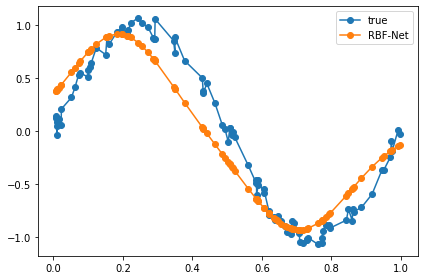

0.04713327054457568


In [97]:
plt.plot(X, y, '-o', label='true')
plt.plot(X, y_pred, '-o', label='RBF-Net')
plt.legend()

plt.tight_layout()
plt.show()

print(mean_squared_error(y,y_pred))

In [98]:
# Cargamos los nuevos datos

import pandas as pd

training = pd.read_csv("../datos/preprocesados/training_horas.csv")
test = pd.read_csv("../datos/preprocesados/test_horas.csv")

x_train = training.to_numpy()[:,:-1]
y_train = training.to_numpy()[:,-1]

x_test = test.to_numpy()[:,:-1]
y_test = test.to_numpy()[:,-1]

In [100]:
rbfnet = GeneticRBFNet(verbose=True)
rbfnet.fit(x_train, y_train, tam_poblacion=100, iteraciones=10000)

y_pred = rbfnet.predict(x_test)
print(mean_squared_error(y_pred, y_test))

ValueError: y_true and y_pred have different number of output (1!=23)

In [101]:
rbfnet = RBFNet(verbose=True)
rbfnet.fit(x_train, y_train)

y_pred = rbfnet.predict(x_test)
print(mean_squared_error(y_pred, y_test))

Loss: 843.67


ValueError: operands could not be broadcast together with shapes (2,) (2,23) 